In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import torch
import numpy as np
import smplx

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp

support_dir = './data'

In [3]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
comp_device

device(type='cpu')

In [4]:
amass_npz_fname = osp.join(support_dir, 'YOGI_2_latest_smplx_neutral/train/220923_yogi_body_hands_03596_Boat_Pose_or_Paripurna_Navasana_-a_stageii.npz') # the path to body data
bdata = np.load(amass_npz_fname)

# you can set the gender manually and if it differs from data's then contact or interpenetration issues might happen
subject_gender = bdata['gender']

print('Data keys available:%s'%list(bdata.keys()))

print('The subject of the mocap sequence is  {}.'.format(subject_gender))


Data keys available:['gender', 'surface_model_type', 'mocap_frame_rate', 'mocap_time_length', 'trans', 'poses', 'betas', 'num_betas', 'root_orient', 'pose_body', 'pose_jaw', 'pose_eye', 'pose_hand']
The subject of the mocap sequence is  neutral.


In [5]:
from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/{}/model.npz'.format(subject_gender))
# dmpl_fname = osp.join(support_dir, 'body_models/dmpls/{}/model.npz'.format(subject_gender))

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

# bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas, num_dmpls=num_dmpls, dmpl_fname=dmpl_fname).to(comp_device)
bm = BodyModel(f'{support_dir}/models_lockedhead/smplx/SMPLX_NEUTRAL.npz', 'smplx', num_betas=num_betas).to(comp_device)
faces = c2c(bm.f)

In [6]:
time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(bdata['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    # 'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in body_parms.items()])))
print('time_length = {}'.format(time_length))


Body parameter vector shapes: 
root_orient: torch.Size([892, 3]) 
pose_body: torch.Size([892, 63]) 
pose_hand: torch.Size([892, 99]) 
trans: torch.Size([892, 3]) 
betas: torch.Size([892, 16])
time_length = 892


In [7]:
list(np.load(f'{support_dir}/models_lockedhead/smplx/SMPLX_NEUTRAL.npz').keys())

['bs_type',
 'bs_style',
 'J_regressor_prior',
 'f',
 'J_regressor',
 'kintree_table',
 'J',
 'weights_prior',
 'weights',
 'vert_sym_idxs',
 'posedirs',
 'v_template',
 'shapedirs',
 'hands_meanr',
 'hands_meanl',
 'lmk_bary_coords',
 'vt',
 'part2num',
 'hands_coeffsr',
 'lmk_faces_idx',
 'dynamic_lmk_faces_idx',
 'hands_componentsr',
 'dynamic_lmk_bary_coords',
 'ft',
 'hands_componentsl',
 'joint2num',
 'allow_pickle',
 'hands_coeffsl']

In [21]:
amass_npz_fname

'./data/YOGI_2_latest_smplx_neutral/train/220923_yogi_body_hands_03596_Boat_Pose_or_Paripurna_Navasana_-a_stageii.npz'

In [8]:
model = smplx.create(f'{support_dir}/models_lockedhead', model_type='smplx',
                         gender='neutral', use_face_contour=False,
                         num_betas=10,
                         num_expression_coeffs=10,
                         ext='npz')
model

SMPLX(
  Gender: NEUTRAL
  Number of joints: 55
  Betas: 10
  Number of PCA components: 6
  Flat hand mean: False
  Number of Expression Coefficients: 10
  (vertex_joint_selector): VertexJointSelector()
)

In [20]:
model = smplx.create(amass_npz_fname, model_type='smplx',
                         gender='neutral', use_face_contour=False,
                         num_betas=10,
                         num_expression_coeffs=10,
                         ext='npz')
model

ValueError: Unknown model type 220923, exiting!

In [9]:
sample_shape, sample_expression = True, True

betas, expression = None, None
if sample_shape:
    betas = torch.randn([1, model.num_betas], dtype=torch.float32)
if sample_expression:
    expression = torch.randn(
        [1, model.num_expression_coeffs], dtype=torch.float32)

output = model(betas=betas, expression=expression,
               return_verts=True)
vertices = output.vertices.detach().cpu().numpy().squeeze()
joints = output.joints.detach().cpu().numpy().squeeze()

print('Vertices shape =', vertices.shape)
print('Joints shape =', joints.shape)

Vertices shape = (10475, 3)
Joints shape = (127, 3)


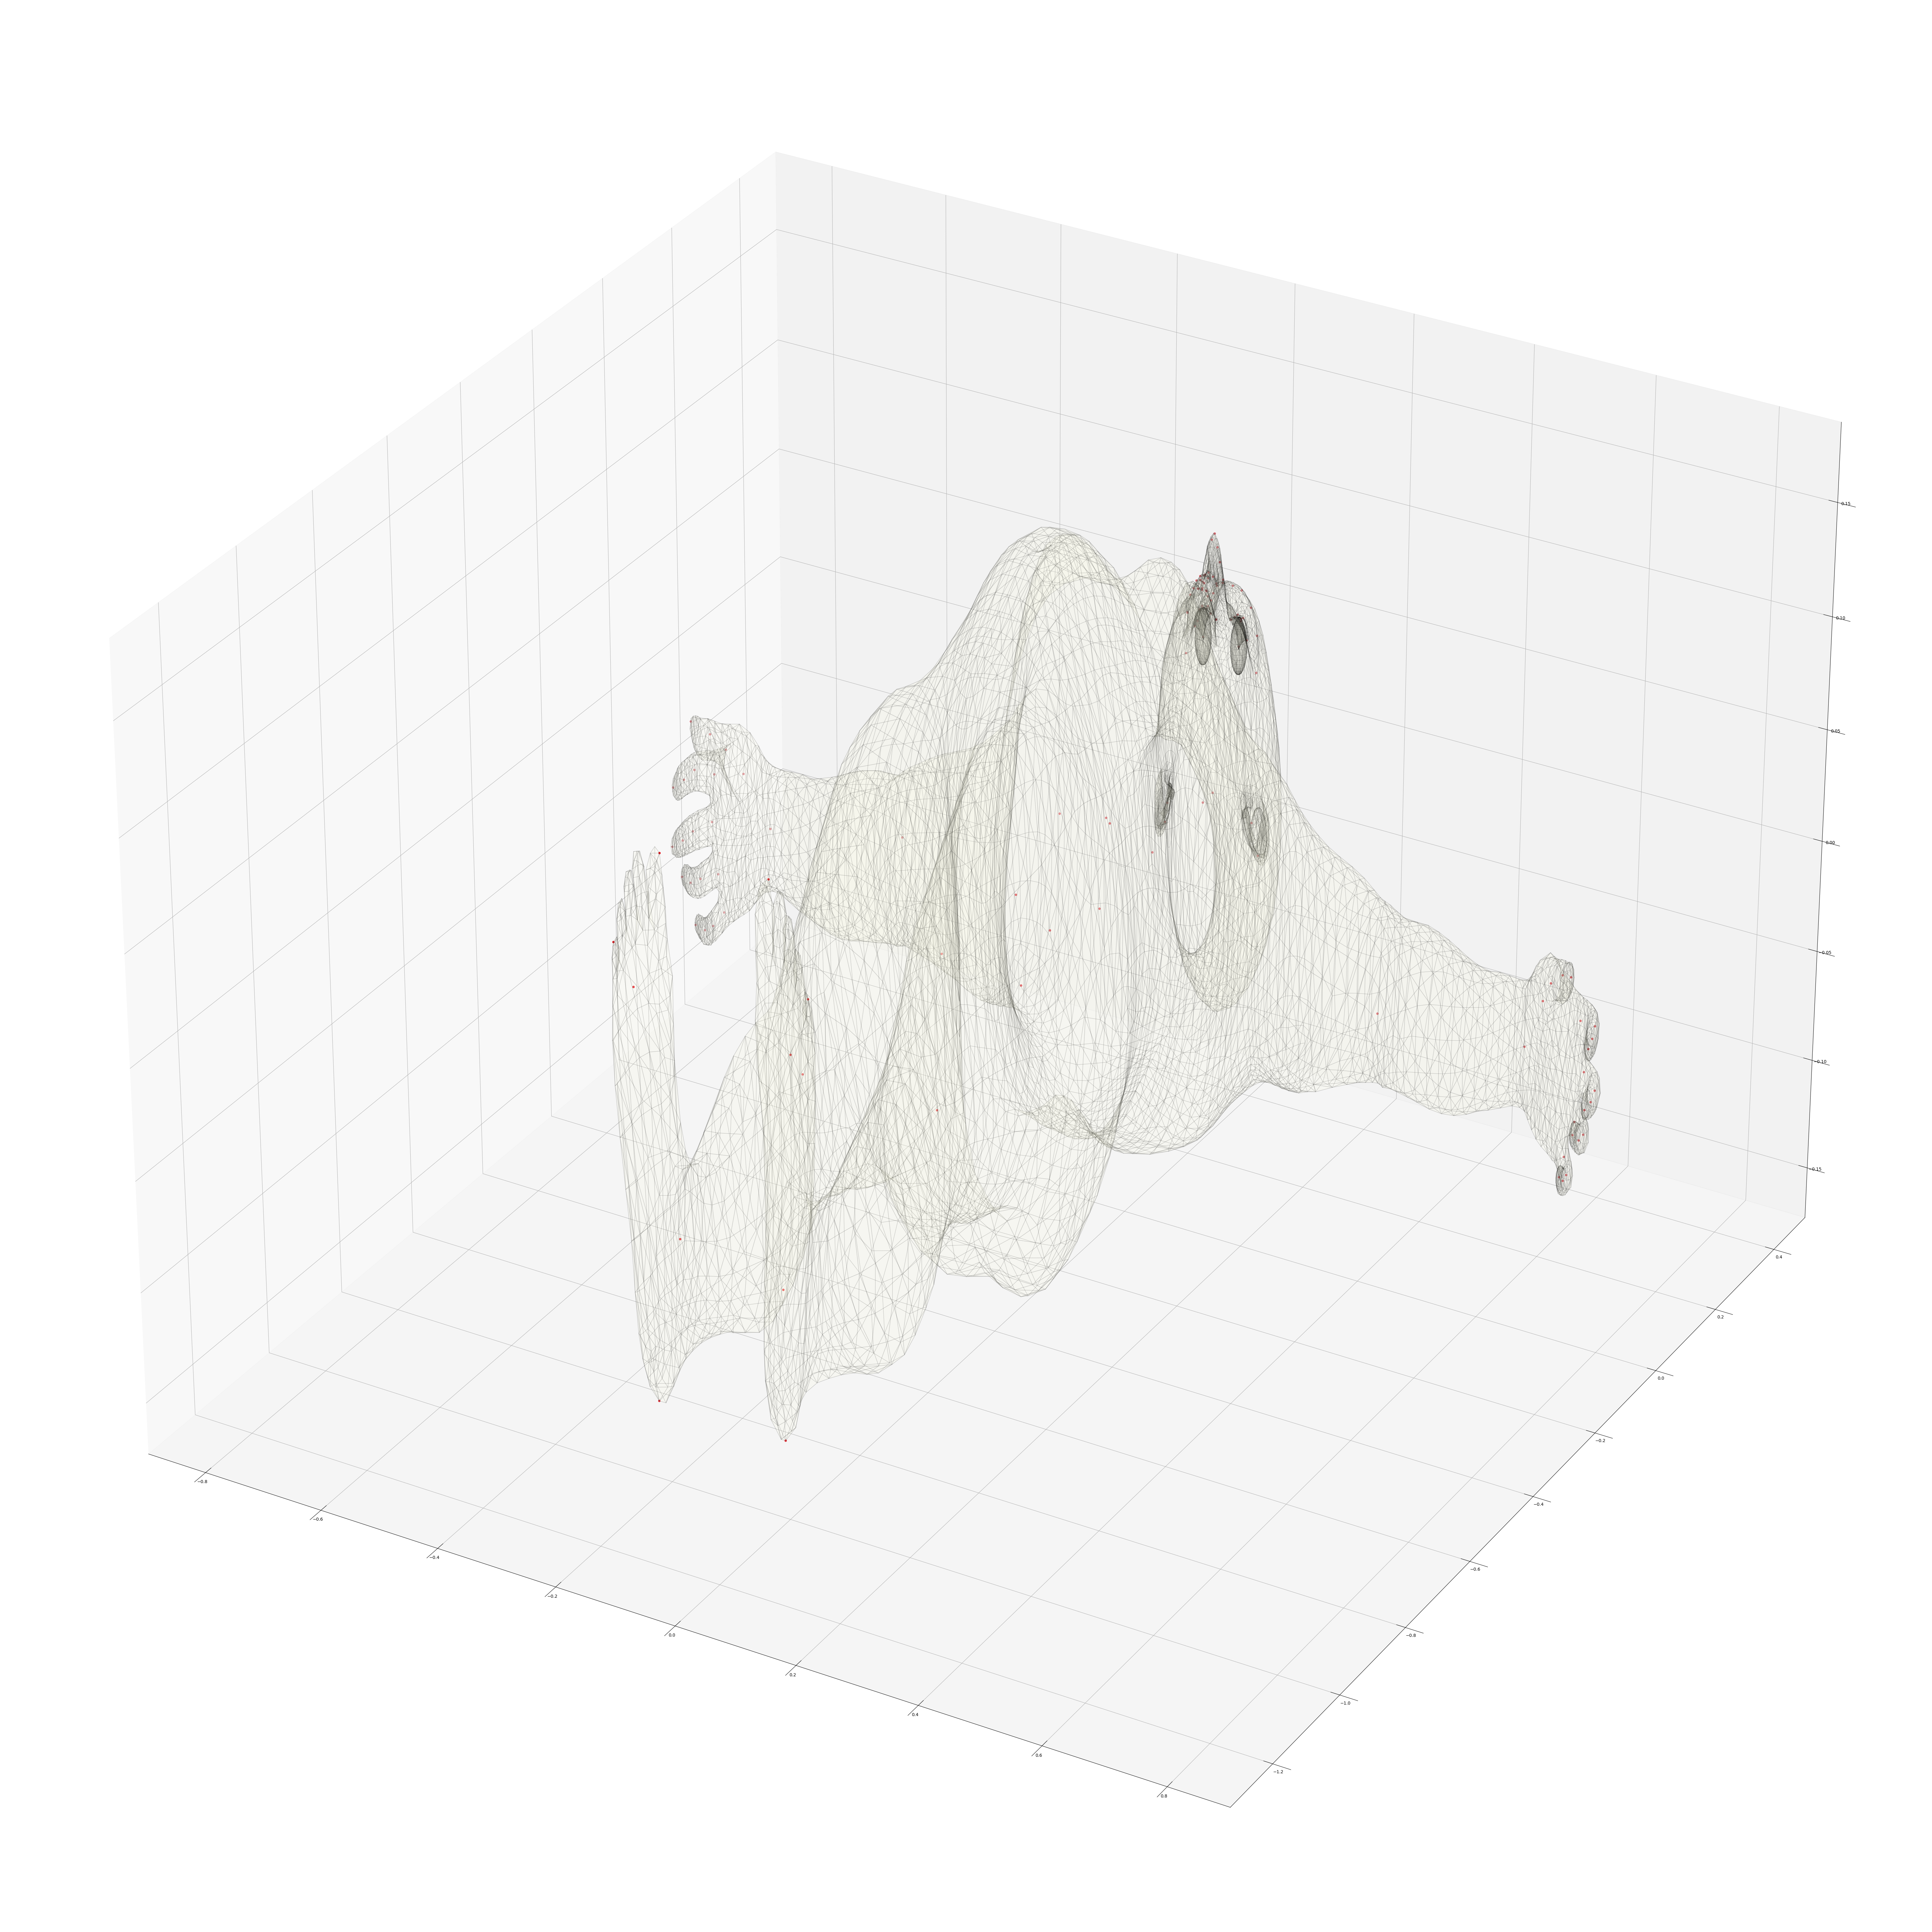

In [19]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plot_joints = True

fig = plt.figure(figsize=(80,100))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(vertices[model.faces], alpha=0.1)
face_color = (1.0, 1.0, 0.9)
edge_color = (0, 0, 0)
mesh.set_edgecolor(edge_color)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color='r')

if plot_joints:
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], alpha=0.1)
plt.show()

In [13]:
from body_visualizer.tools.vis_tools import render_smpl_params
from body_visualizer.tools.vis_tools import imagearray2file
from body_visualizer.tools.vis_tools import show_image

In [14]:
#Loading VPoser Body Pose Prior
from human_body_prior.tools.model_loader import load_model
from human_body_prior.models.vposer_model import VPoser
vp, ps = load_model(expr_dir, model_code=VPoser,
                              remove_words_in_model_weights='vp_model.',
                              disable_grad=True)

ImportError: cannot import name 'load_model' from 'human_body_prior.tools.model_loader' (/opt/homebrew/Caskroom/miniforge/base/envs/moyo/lib/python3.9/site-packages/human_body_prior/tools/model_loader.py)